In [46]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import sqrtm

In [38]:
dead = pd.read_csv('core/dead-reckoning.csv', index_col=0, parse_dates=True)
truth = pd.read_csv('core/data/test_data.csv', index_col=0, parse_dates=True)
closed = pd.read_csv('core/closed_loop.csv', index_col=0, parse_dates=True)

/tmp/ipykernel_516341/1496622507.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dead = pd.read_csv('core/dead-reckoning.csv', index_col=0, parse_dates=True)
/tmp/ipykernel_516341/1496622507.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  closed = pd.read_csv('core/closed_loop.csv', index_col=0, parse_dates=True)


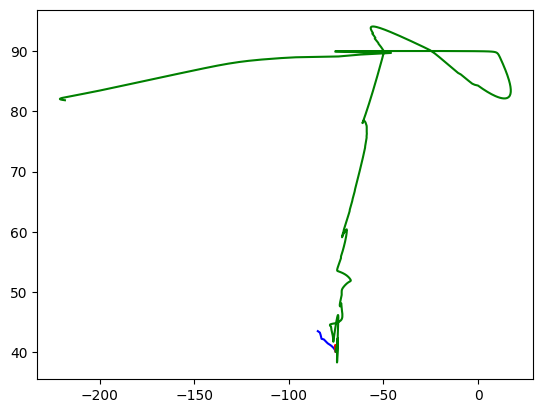

In [39]:
plt.plot(dead['longitude'], dead['latitude'], label='Dead Reckoning', color='blue')
plt.plot(truth['longitude'], truth['latitude'], label='Ground Truth', color='red')
plt.plot(closed['longitude'], closed['latitude'], label='Closed Loop', color='green')

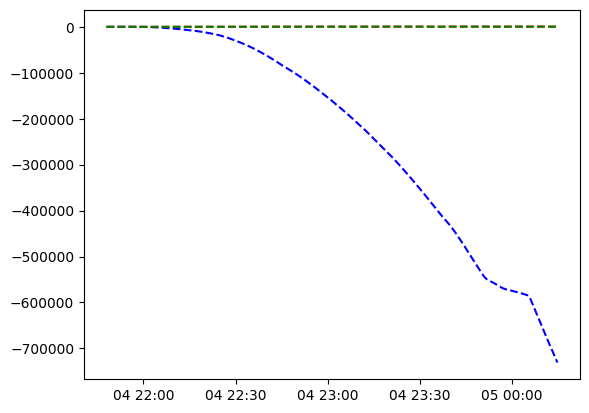

In [34]:
plt.plot(truth.index, dead['altitude'], label='Dead Reckoning Altitude', color='blue', linestyle='--')
plt.plot(truth.index, truth['altitude'], label='Ground Truth Altitude', color='red', linestyle='--')
plt.plot(truth.index, closed['altitude'], label='Closed Loop Altitude', color='green', linestyle='--')

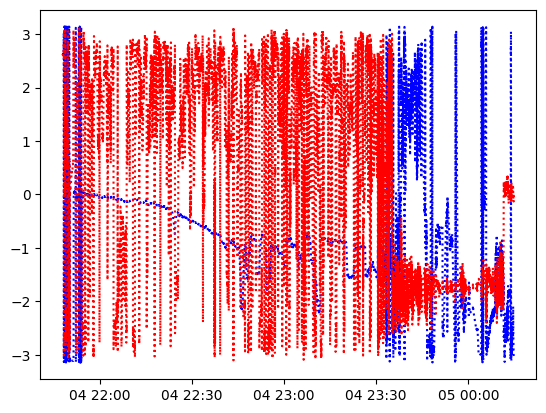

In [15]:
plt.plot(truth.index, dead['roll'], label='Dead Reckoning Roll', color='blue', linestyle=':')
plt.plot(truth.index, truth['roll'], label='Ground Truth Roll', color='red', linestyle=':')

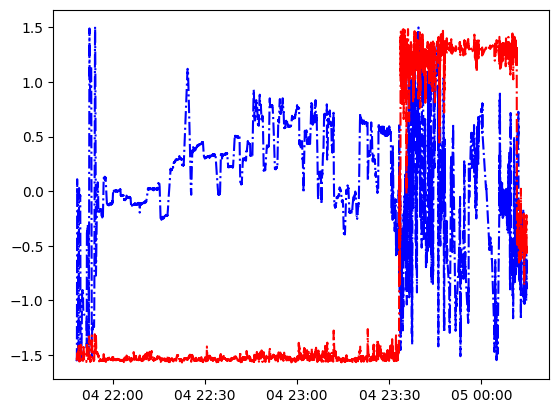

In [16]:
plt.plot(truth.index, dead['pitch'], label='Dead Reckoning Pitch', color='blue', linestyle='-.')
plt.plot(truth.index, truth['pitch'], label='Ground Truth Pitch', color='red', linestyle='-.')


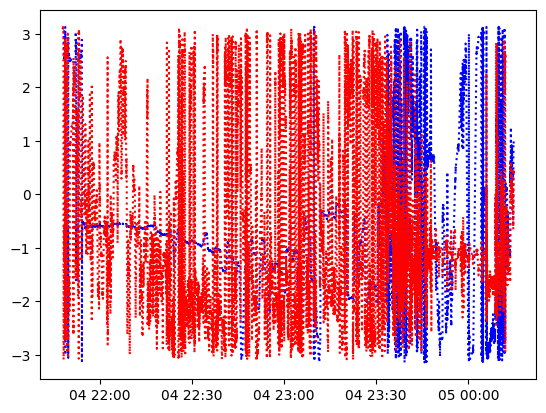

In [17]:
plt.plot(truth.index, dead['yaw'], label='Dead Reckoning Yaw', color='blue', linestyle=':')
plt.plot(truth.index, truth['yaw'], label='Ground Truth Yaw', color='red', linestyle=':')

In [51]:
covar = np.array([9.315089176579114e-11, -7.546538691920412e-17, -7.624300488936675e-12, 4.96432833727772e-10, -1.7722210424913776e-10, 3.1369439774329293e-11, 1.5449741517956884e-11, -1.2782963448844738e-10, -7.129496208317938e-12, 1.8835646552838673e-12, -5.846819765385293e-13, 1.0818942479800102e-12, -2.3847421733270327e-13, -2.137722622877268e-12, -1.5702093737505092e-12, -7.546538691920412e-17, 9.315104321693182e-11, 1.1966224697191895e-13, -2.2634281286414665e-10, 7.835837641659079e-10, -2.2935142438170056e-11, 1.06690995138149e-10, 9.86186691207601e-11, -5.336240885212376e-11, 4.941423214853108e-13, -1.4170901153559237e-12, -2.4695622411798175e-12, -7.39407644633286e-13, 2.066369642918308e-12, -2.4053522292635745e-12, -7.624300488936669e-12, 1.1966224759641938e-13, 6.063063883313676e-5, -6.95496821497218e-5, 3.191009913574276e-5, 5.0803886589826824e-5, -4.187470319221582e-6, 8.517011919602685e-5, -1.9148120376338086e-7, -7.643183460992345e-8, 3.034430650245861e-8, 9.229608667738963e-8, 9.93048032176597e-8, -6.388437972551937e-7, -1.1566314184778486e-7, 4.964328337354742e-10, -2.2634281286425072e-10, -6.954968216587441e-5, 0.0023225233095408946, -0.0010330741450947844, -4.919877343459415e-5, 1.4391107043991414e-5, -0.0006106338741779456, -8.407545934330326e-5, 3.868842039465942e-6, -2.3146811947307045e-8, 7.691550628059939e-7, 3.0492043299485e-7, -9.318768004960657e-6, -7.668395101911498e-6, -1.772221042500745e-10, 7.835837641593506e-10, 3.1910099142727676e-5, -0.0010330741450650983, 0.0023932236560704847, 4.714308324582625e-5, 0.00031227671607018443, 0.0003903931760209229, -0.0001766654512082565, 1.298340311582538e-6, -7.278814011661905e-7, -6.015005897665738e-6, -6.907615434166943e-7, 8.46564796160296e-6, -7.3372099082128405e-6, 3.13694397715711e-11, -2.2935142441448684e-11, 5.080388658982677e-5, -4.919877343372103e-5, 4.7143083273765907e-5, 0.0001528011289277268, 2.0962362428680194e-5, 9.620959927151686e-5, -9.506823399609785e-6, -3.1368570580468695e-7, 1.3752863271406196e-7, -9.765896884791958e-8, -1.6116662339691203e-7, -1.4033546017812155e-6, -2.7300692235100266e-7, 1.5449741517501518e-11, 1.0669099513770666e-10, -4.1874703192215785e-6, 1.4391107044100555e-5, 0.00031227671607018443, 2.096236242606085e-5, 9.644395946065494e-5, 9.686992373315755e-6, 6.727958850934729e-6, 5.309975282609502e-7, 7.420408302943961e-7, -1.265768812254153e-6, -2.465631742573263e-6, 6.408057867369241e-7, -7.585217296874315e-7, -1.2782963448844738e-10, 9.861866912081216e-11, 8.51701192027935e-5, -0.0006106338741783821, 0.0003903931760226691, 9.620959926977063e-5, 9.686992371569527e-6, 0.00015003219692629168, -4.2702092756424365e-6, 9.781981567086111e-8, -1.5449047024679905e-7, 4.633066217354332e-7, 5.750739384631572e-7, 2.299465999667708e-6, 5.726999423196635e-7, -7.129496208324443e-12, -5.3362408852104234e-11, -1.9148120458192587e-7, -8.407545934330326e-5, -0.0001766654512084202, -9.50682339873667e-6, 6.727958850764199e-6, -4.270209275533297e-6, 0.00010582260872424846, -5.934307265290201e-8, -2.521919906102192e-7, 6.182250899166042e-7, -2.8227316209991944e-6, -5.813318577405898e-7, 3.6855396264977454e-6, 1.8835646552838423e-12, 4.941423214853234e-13, -7.643183460987015e-8, 3.868842039465942e-6, 1.298340311582538e-6, -3.1368570580458033e-7, 5.309975282609502e-7, 9.78198156708078e-8, -5.9343072652921994e-8, 2.7459116488399615e-7, -9.713770450820742e-9, 1.5308220384738446e-8, 1.6837384680067468e-9, 1.01965081290816e-8, -4.772873142110152e-9, -5.846819765385293e-13, -1.4170901153559237e-12, 3.034430650245861e-8, -2.3146811947200464e-8, -7.278814011666168e-7, 1.375286327138488e-7, 7.420408302944227e-7, -1.5449047024679905e-7, -2.5219199061021254e-7, -9.713770450820742e-9, 3.169461282220632e-7, 2.4868633085866504e-8, -5.854325219130227e-9, 8.283074533205004e-9, -1.291687518880771e-8, 1.0818942479800102e-12, -2.4695622411798045e-12, 9.229608667733634e-8, 7.691550628059939e-7, -6.015005897665738e-6, -9.765896884791953e-8, -1.2657688122541266e-6, 4.633066217354332e-7, 6.182250899166176e-7, 1.5308220384738446e-8, 2.4868633085866497e-8, 2.7645294167510224e-7, 9.596615092131621e-9, 2.7188333605391082e-9, 3.082618028413364e-8, -2.3847421733269055e-13, -7.394076446332859e-13, 9.93048032176597e-8, 3.049204329952763e-7, -6.907615434166942e-7, -1.6116662339691203e-7, -2.4656317425732896e-6, 5.750739384631038e-7, -2.8227316209991944e-6, 1.6837384680067454e-9, -5.854325219130217e-9, 9.596615092131614e-9, 3.2525906985875954e-7, 9.892423325337544e-9, -4.9422041493257355e-9, -2.137722622877281e-12, 2.066369642918295e-12, -6.388437972551937e-7, -9.318768004960657e-6, 8.465647961602747e-6, -1.4033546017810029e-6, 6.408057867369374e-7, 2.2994659996676544e-6, -5.813318577405765e-7, 1.0196508129081596e-8, 8.28307453320501e-9, 2.7188333605391082e-9, 9.892423325337544e-9, 2.6641063802298906e-7, -9.945156318754961e-9, -1.5702093737505282e-12, -2.4053522292635806e-12, -1.1566314184767828e-7, -7.668395101911498e-6, -7.337209908212947e-6, -2.7300692235110933e-7, -7.585217296874315e-7, 5.726999423196369e-7, 3.6855396264977454e-6, -4.77287314211015e-9, -1.291687518880771e-8, 3.082618028413364e-8, -4.9422041493257355e-9, -9.94515631875496e-9, 3.105702505879747e-7]).reshape((15, 15))

In [52]:
np.diag(covar)

array([9.31508918e-11, 9.31510432e-11, 6.06306388e-05, 2.32252331e-03,
       2.39322366e-03, 1.52801129e-04, 9.64439595e-05, 1.50032197e-04,
       1.05822609e-04, 2.74591165e-07, 3.16946128e-07, 2.76452942e-07,
       3.25259070e-07, 2.66410638e-07, 3.10570251e-07])

In [53]:
sqrtm(covar)

array([[ 9.65146409e-06+3.96230455e-16j, -1.96634657e-12-2.71150995e-16j,
        -1.28777219e-09-6.61606973e-10j,  1.04133438e-08+3.29463886e-10j,
        -9.60319273e-10-1.03236841e-10j,  3.60990615e-09-4.46664186e-10j,
        -7.03440469e-10+1.13007607e-10j, -1.75610710e-09+1.56888480e-09j,
         2.03821307e-09+6.36395181e-11j,  1.35601869e-09-2.30014419e-11j,
         8.92767571e-11+2.82063545e-12j,  1.27657474e-09-2.20974569e-11j,
        -1.48817127e-10-9.27439502e-12j,  5.88819435e-10-1.11687787e-11j,
        -5.26152901e-10+7.81468488e-12j],
       [-1.96634656e-12-2.71150995e-16j,  9.65146437e-06+1.85555807e-16j,
         5.50305534e-10+4.52755175e-10j, -1.01147590e-09-2.25460864e-10j,
         1.63182626e-08+7.06477050e-11j, -2.60177194e-09+3.05664133e-10j,
         1.09015949e-09-7.73340986e-11j,  6.63662396e-10-1.07362942e-09j,
         2.93749280e-10-4.35502078e-11j, -3.56463078e-10+1.57404959e-11j,
        -1.45360543e-09-1.93023555e-12j, -6.24155028e-10+1.51218750e-1

In [48]:
np.diag(arr)

array([6.21005945e-06, 6.21006955e-06, 4.04204259e+00, 1.54834887e+02,
       1.59548244e+02, 1.01867419e+01, 6.42959730e+00, 1.00021465e+01,
       7.05484058e+00, 1.83060777e-02, 2.11297419e-02, 1.84301961e-02,
       2.16839380e-02, 1.77607092e-02, 2.07046834e-02])

In [54]:
0.5 * (covar + covar.T) == covar

array([[ True,  True, False, False, False, False, False,  True, False,
        False,  True,  True, False, False, False],
       [ True,  True, False, False, False, False, False, False, False,
        False,  True, False, False, False, False],
       [False, False,  True, False, False, False, False, False, False,
        False,  True, False,  True,  True, False],
       [False, False, False,  True, False, False, False, False,  True,
         True, False,  True, False,  True,  True],
       [False, False, False, False,  True, False,  True, False, False,
         True, False,  True, False, False, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False,  True, False, False],
       [False, False, False, False,  True, False,  True, False, False,
         True, False, False, False, False,  True],
       [ True, False, False, False, False, False, False,  True, False,
        False,  True,  True, False, False, False],
       [False, False, Fa